1. Необходимо доработать обучение нейросети, что мы разбирали на уроке.(Посмотрите чего не хватает в процессе обучения и подготовки данных)

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import os

import torch.nn as nn
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch.nn import functional as F

In [3]:
def conv_block(in_channels,  out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels),
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.ReLU(),
        nn.BatchNorm2d(num_features=out_channels)
    )
    return conv

In [4]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]

        return output

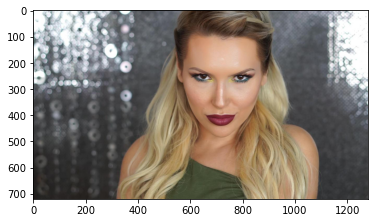

In [5]:
mask = plt.imread('set-lipstick-original/720p/image00000001.jpg')
plt.imshow(mask)
plt.show()

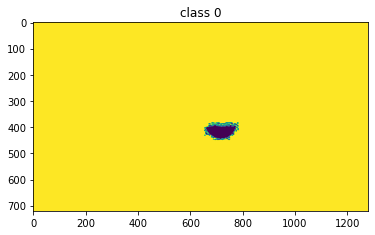

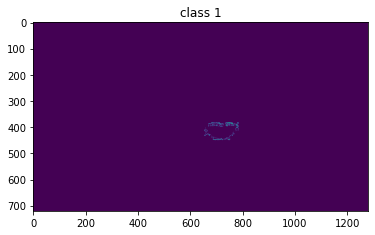

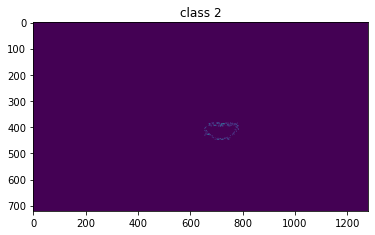

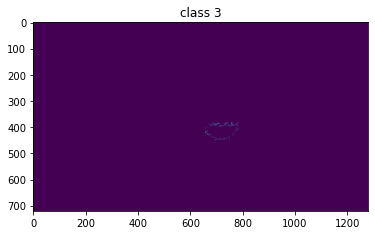

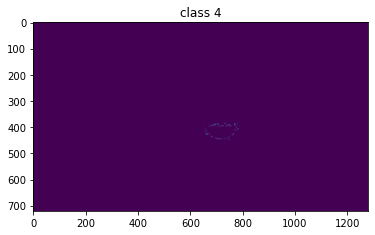

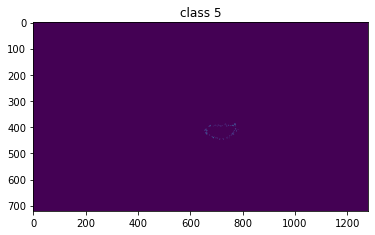

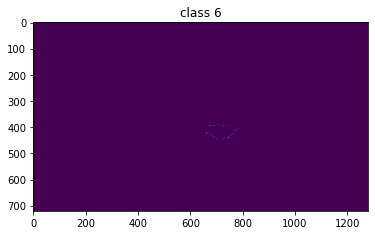

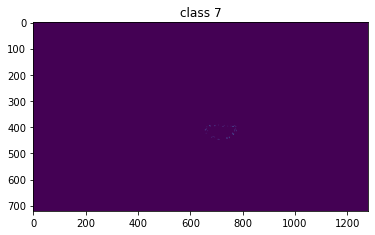

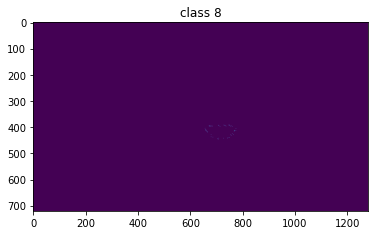

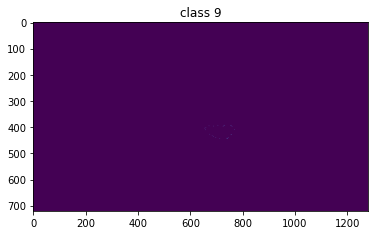

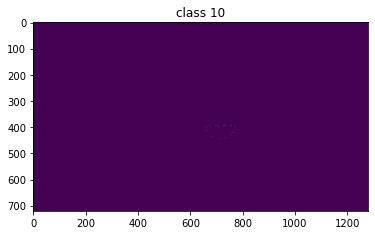

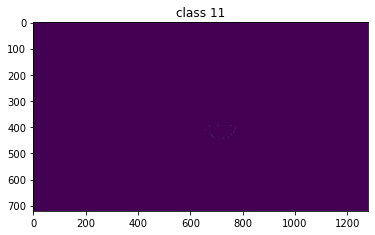

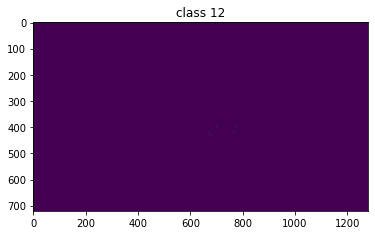

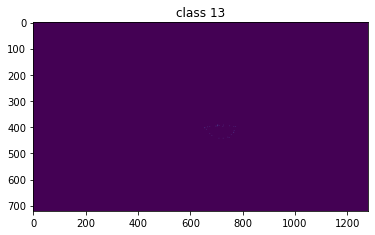

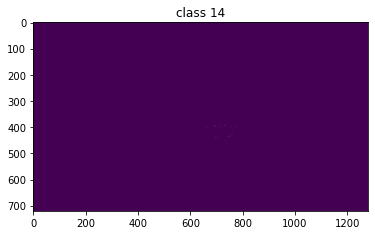

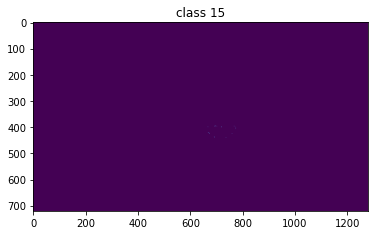

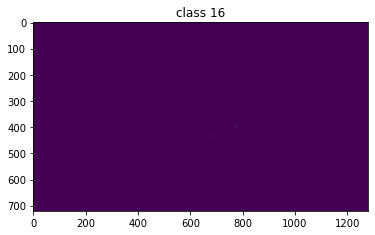

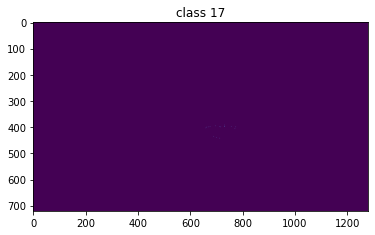

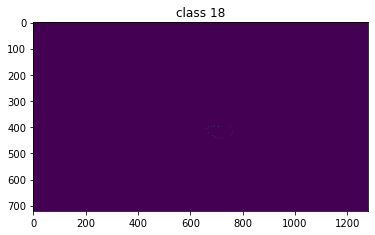

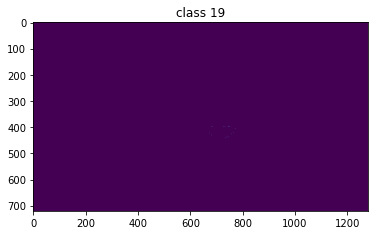

In [6]:
for i in range(20):
    mask = plt.imread('set-lipstick-original/mask/mask00000001.png')*255
    mask = np.where(mask == i, 1, 0)
    mask = mask[:,:,1]
    plt.title(f'class {i}')
    plt.imshow(mask)
    plt.show()

In [7]:
df = pd.read_csv('set-lipstick-original/list.csv', delimiter=',')
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
cameraRGB = []
cameraSeg = []
for i in range(df.shape[0]):
    path_name = os.path.join('set-lipstick-original\\720p', df.iloc[i][0])    
    path_mask = os.path.join('set-lipstick-original\\mask', df.iloc[i][8])
    if os.path.exists(path_name) and os.path.exists(path_mask):
        cameraRGB.append(path_name)
        cameraSeg.append(path_mask)

In [9]:
df = pd.DataFrame({'cameraRGB': cameraRGB, 'cameraSeg': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='cameraRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
df.head()

,cameraRGB,cameraSeg
0,set-lipstick-original\720p\image00000001.jpg,set-lipstick-original\mask\mask00000001.png
1,set-lipstick-original\720p\image00000002.jpg,set-lipstick-original\mask\mask00000002.png
2,set-lipstick-original\720p\image00000003.jpg,set-lipstick-original\mask\mask00000003.png
3,set-lipstick-original\720p\image00000004.jpg,set-lipstick-original\mask\mask00000004.png
4,set-lipstick-original\720p\image00000005.jpg,set-lipstick-original\mask\mask00000005.png


In [10]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = np.asarray(Image.open(self.image_arr[index])).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # 1) unsqueeze - меняет размерность img c (600, 800, 3) -> (1, 600, 800, 3),
        # т.е. оборачивает картинку в батч размером в одну картинку
        # 2) permute - меняет местами измерения , т.е. (1, 600, 800, 3) -> (1, 3, 600, 800)
        img = img.unsqueeze(0).permute(0,3,1,2)
        # Мы используем функцию интерполяции для того,
        # чтобы поменять рамерность картинки с 800х600 на 256х256
        img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
        
        # итаем сегментированную картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        lab = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
        
        # Упаковываем ее в pytorch-тензор и оборачиваем ее в батч из одной каринки,
        # но при этом заполняем 13 каналов масками нужных классов
        # Т.е. там, где например класс автомобилей (10 по счету канал) - все пиксели 0 
        # если не принадлежат классу, и 1 если принадлежат 
        x_out = torch.as_tensor(np.where(lab == 0, 255, 0)).unsqueeze(0)
        for i in range(1, 2):
            mask = np.asarray(plt.imread(self.label_arr[index]))[:,:,0]*255
            mask = np.where(mask == i, 255, 0)
            x = torch.as_tensor(mask).unsqueeze(0)
            x_out =  torch.cat((x_out,x),dim=0)    
        x_out = x_out.float()
        
        lab = x_out.unsqueeze(0)
        # делаем ресайз картинки на 256х256
        lab = F.interpolate(input=lab, size=256, mode='nearest')
        
        
        
        return (img.float(), lab.float())

    def __len__(self):
        return self.data_len

In [11]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [12]:
train_data_loader = DataLoader(train_data, batch_size=8, shuffle=False)
test_data_loader = DataLoader(train_data, batch_size=8, shuffle=False)

Обучение

In [13]:
learning_rate = 0.001
epochs = 5

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device("cpu")
print(device)

cuda


In [15]:
import segmentation_models_pytorch as smp
Umodel = smp.Unet('resnet34', classes=2, activation='softmax').to(device)

In [16]:
optimizer = torch.optim.Adam(Umodel.parameters(), lr=learning_rate)

In [17]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth =1
        num = targets.size(0)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score =2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score =1 - score.sum() / num
        return score

In [18]:
criterion = SoftDiceLoss()

In [19]:
total_steps = len(train_data_loader)
print(f"{epochs} epochs, {total_steps} total_steps per epoch")

5 epochs, 2498 total_steps per epoch


In [21]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
#torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    epoch_loss = []
    t = 0
    time1 = time.time()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Umodel(inputs[0])
        loss = criterion(outputs,labels[0,0,:,:,:])
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_loss.append(loss.item())
        t+=1
        if t % 500 == 499:    # print every 500 mini-batches
            print(f'Epoch: {epoch}, batchcount: {t}, avg. loss for last 500 images: {running_loss/500}')
            running_loss = 0
    time2 = time.time()
    print(f'Epoch {epoch+1}, loss: ',np.mean(epoch_loss),f' time = {time2-time1} sec')
    epoch_losses.append(epoch_loss)

Epoch: 0, batchcount: 499, avg. loss for last 500 images: 0.12677912557125093
Epoch: 0, batchcount: 999, avg. loss for last 500 images: 0.12411070156097412


TypeError: No loop matching the specified signature and casting was found for ufunc true_divide

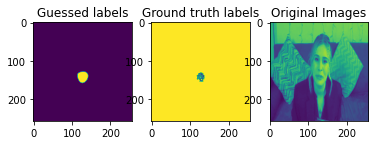

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

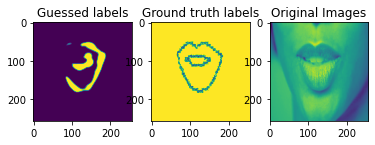

<Figure size 432x288 with 0 Axes>

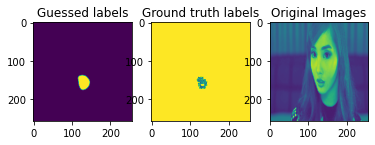

<Figure size 432x288 with 0 Axes>

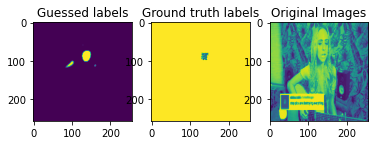

<Figure size 432x288 with 0 Axes>

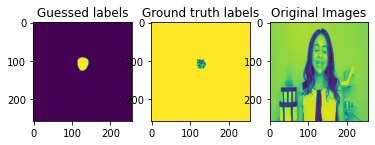

<Figure size 432x288 with 0 Axes>

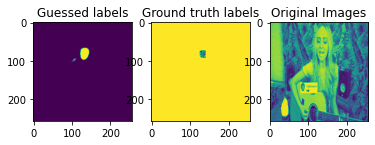

<Figure size 432x288 with 0 Axes>

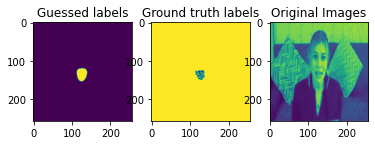

<Figure size 432x288 with 0 Axes>

In [22]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    outputs = Umodel(images[0])
    f, axarr = plt.subplots(1,3)

    axarr[0].imshow(outputs[0].detach().cpu().numpy()[1,:,:])
    axarr[0].set_title('Guessed labels')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[1].set_title('Ground truth labels')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break

In [ ]:
for i, data in enumerate(train_data_loader):
    images, labels = data
    f, axarr = plt.subplots(1,3)
    
    axarr[0].imshow(labels[0].detach().cpu().numpy()[0,0,:,:])
    axarr[0].set_title('class 0')
    
    axarr[1].imshow(labels[0].detach().cpu().numpy()[0,1,:,:])
    axarr[1].set_title('class 1')
    
    axarr[2].imshow(images[0].detach().cpu().numpy()[0,0,:,:])
    axarr[2].set_title('Original Images')
    plt.show()
    plt.gcf().show()
    if i>5:
        break